# BloodMNIST Classification Pipeline

This notebook orchestrates the complete pipeline for blood cell type classification using the BloodMNIST dataset.

## Pipeline Overview:
1. **Import Libraries & Modules** - Load required dependencies
2. **Configuration** - Set hyperparameters and options
3. **Data Preparation** - Load and transform the dataset
4. **Data Exploration** - Visualize and understand the data
5. **Model Training** - Train classification models (TODO)
6. **Evaluation** - Assess model performance (TODO)

## 1. Import Libraries & Modules

In [1]:
import torch
import torch.nn as nn
import medmnist

# import custom modules from the backend directory
from backend.data_loading import (
    get_data_transforms,
    load_blood_mnist_datasets,
    print_dataset_info,
    create_dataloaders,
    show_image_batch
)
from backend.models.MLP import build_baseline_mlp
from backend.model_management import (
    record_experiment,
    list_result_runs,
    load_experiment
)
from backend.training import (
    train_model,
    predict_labels,
    compute_confusion_matrix
)

/home/nuno/python_envs/ML/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Configuration

Set the hyperparameters and configuration options for the pipeline.

In [2]:
# configuration parameters
BATCH_SIZE = 128 
DOWNLOAD = True   # download the dataset if not found locally

print(f"Configuration:")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Download Dataset: {DOWNLOAD}")

Configuration:
  Batch Size: 128
  Download Dataset: True


## 3. Data Preparation

### 3.1 Get Data Transformations

Define the preprocessing transformations to be applied to images.

In [3]:
print("=== Step 1: Preparing data transformations ===")
data_transform = get_data_transforms()
print("Data transformations prepared")

=== Step 1: Preparing data transformations ===
Data transformations prepared


### 3.2 Load BloodMNIST Datasets

Download and load the train, validation, and test splits.

In [4]:
print("=== Step 2: Loading BloodMNIST datasets ===")
train_dataset, val_dataset, test_dataset = load_blood_mnist_datasets(
    data_transform=data_transform,
    download=DOWNLOAD
)
print("Datasets loaded successfully")

=== Step 2: Loading BloodMNIST datasets ===
Datasets loaded successfully


### 3.3 Dataset Information

Display detailed information about the dataset splits and classes.

In [5]:
print_dataset_info(train_dataset, val_dataset, test_dataset)


Dataset Information:
Number of training samples: 11959
Number of validation samples: 1712
Number of test samples: 3421
Task: multi-class
Number of channels: 3
Number of classes: 8
Class labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}


### 3.4 Create DataLoaders

Create PyTorch DataLoaders for efficient batch processing.

In [6]:
print("=== Step 3: Creating DataLoaders ===")
train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    batch_size=BATCH_SIZE
)
print("DataLoaders created successfully")

=== Step 3: Creating DataLoaders ===

Created DataLoaders with batch size 128.
DataLoaders created successfully


## 4. Data Exploration

### 4.1 Visualize Training Data

Display a batch of training images to understand the data we're working with.

=== Step 4: Visualizing training data ===

Labels for the first row of images:
neutrophil, platelet, lymphocyte, eosinophil, platelet, neutrophil, monocyte, lymphocyte, basophil, lymphocyte, monocyte, immature granulocytes(myelocytes, metamyelocytes and promyelocytes), lymphocyte, erythroblast, immature granulocytes(myelocytes, metamyelocytes and promyelocytes), immature granulocytes(myelocytes, metamyelocytes and promyelocytes)


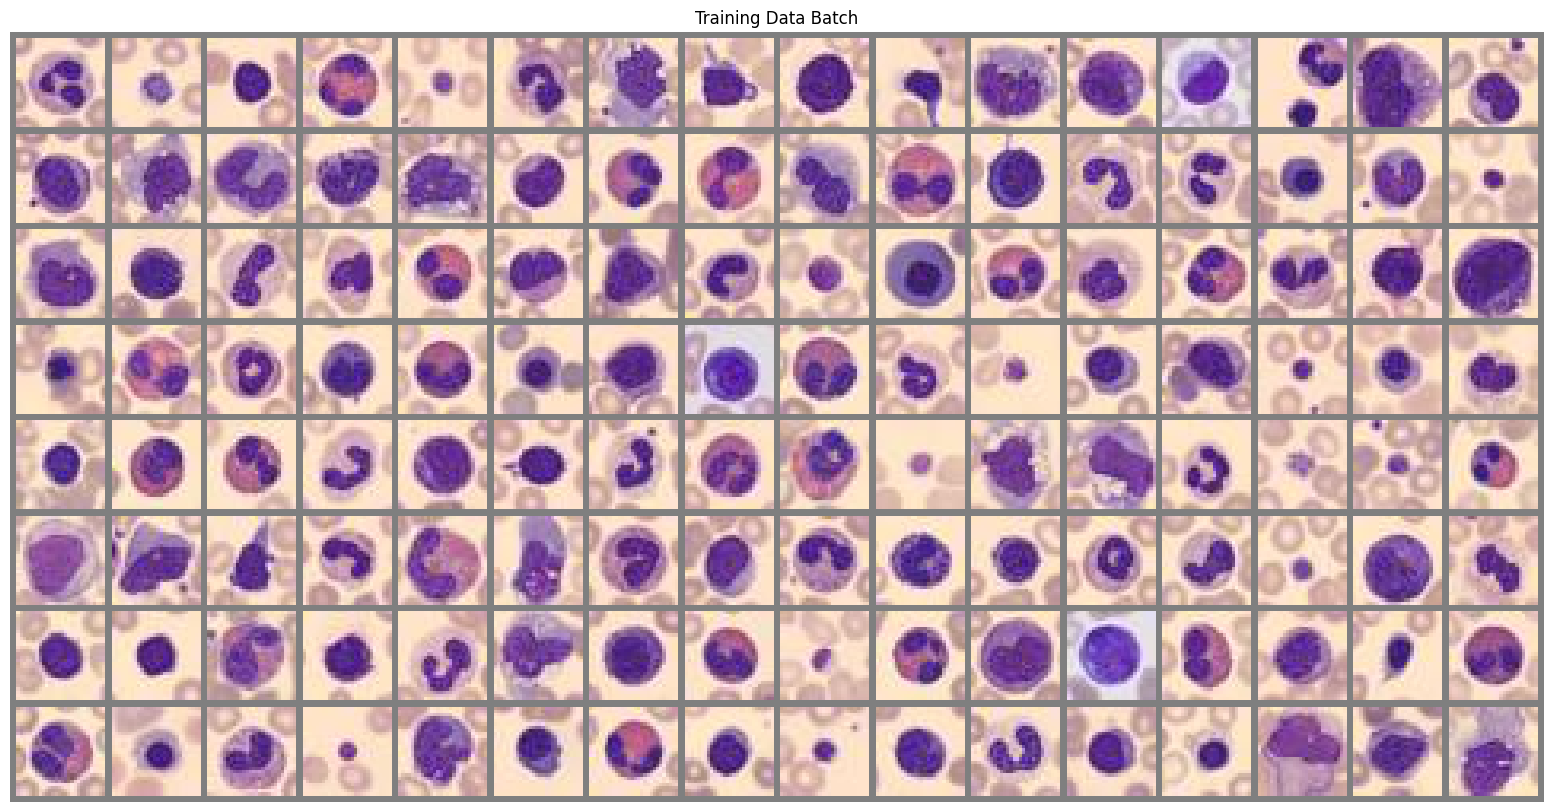

In [7]:
print("=== Step 4: Visualizing training data ===")
show_image_batch(
    data_loader=train_loader,
    dataset=train_dataset,
    title="Training Data Batch"
)

## 5. Baseline MLP Setup

Instantiate the baseline classifier and keep the loss and optimizer easy to tweak.

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mlp_architecture = {
    "input_shape": (3, 28, 28),
    "hidden_dims": [512, 256],
    "num_classes": len(train_dataset.info["label"]),
    "dropout": 0.2,
}

model = build_baseline_mlp(**mlp_architecture).to(device)
current_config = model.get_config()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(f"Model on {device}: {model.__class__.__name__}")
print(f"Architecture: {current_config}")

Model on cpu: BaselineMLP
Architecture: {'input_shape': (3, 28, 28), 'hidden_dims': [512, 256], 'num_classes': 8, 'dropout': 0.2}


## 6. Experiment Tracking

Keep track of saved experiment runs and make reloading straightforward.

In [9]:
existing_runs = list_result_runs(model.__class__.__name__)
print(f"Existing runs for {model.__class__.__name__}: {existing_runs}")

LOAD_RESULTS_DIR = None  # e.g., "../results/BaselineMLP_20251020-153000"

if LOAD_RESULTS_DIR:
    metadata = load_experiment(
        model=model,
        results_dir=LOAD_RESULTS_DIR,
        optimizer=optimizer,
        criterion=criterion,
        map_location=device,
    )
    mlp_architecture = metadata["architecture"]
    current_config = metadata["architecture"]
    if metadata["architecture"] != model.get_config():
        print(
            "Warning: Loaded architecture metadata differs from instantiated model. "
            "Rebuild the model if needed before continuing.",
        )
    print(f"Loaded experiment from {LOAD_RESULTS_DIR}")
    print(f"Loaded architecture: {current_config}")

Existing runs for BaselineMLP: [PosixPath('/home/nuno/Documents/Blood-Cell-Types-Classifier/results/BaselineMLP_20251020-153848'), PosixPath('/home/nuno/Documents/Blood-Cell-Types-Classifier/results/BaselineMLP_20251020-154323'), PosixPath('/home/nuno/Documents/Blood-Cell-Types-Classifier/results/BaselineMLP_20251020-154348'), PosixPath('/home/nuno/Documents/Blood-Cell-Types-Classifier/results/BaselineMLP_20251020-154448')]


## 7. Model Training

Run the baseline MLP training loop and report epoch metrics.

In [10]:
EPOCHS = 5
training_history, best_state = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=EPOCHS,
 )
model.load_state_dict(best_state)

print("Training summary:")
for epoch_idx, metrics in enumerate(training_history, start=1):
    msg = (
        f"Epoch {epoch_idx}: "
        f"train_loss={metrics.train_loss:.4f}, "
        f"train_acc={metrics.train_accuracy:.4f}"
    )
    if metrics.val_loss is not None and metrics.val_accuracy is not None:
        msg += (
            f", val_loss={metrics.val_loss:.4f}, "
            f"val_acc={metrics.val_accuracy:.4f}"
        )
    print(msg)

if any(m.val_accuracy is not None for m in training_history):
    best_epoch, best_metrics = max(
        enumerate(training_history, start=1),
        key=lambda item: item[1].val_accuracy if item[1].val_accuracy is not None else float("-inf"),
    )
    print(
        f"Best validation accuracy {best_metrics.val_accuracy:.4f} "
        f"achieved at epoch {best_epoch}.",
    )

Training summary:
Epoch 1: train_loss=0.9902, train_acc=0.6274, val_loss=0.6693, val_acc=0.7629
Epoch 2: train_loss=0.6541, train_acc=0.7650, val_loss=0.5562, val_acc=0.7938
Epoch 3: train_loss=0.5738, train_acc=0.7951, val_loss=0.4896, val_acc=0.8329
Epoch 4: train_loss=0.5249, train_acc=0.8103, val_loss=0.4725, val_acc=0.8248
Epoch 5: train_loss=0.4914, train_acc=0.8209, val_loss=0.6019, val_acc=0.7757
Best validation accuracy 0.8329 achieved at epoch 3.


## 8. Model Evaluation

Generate a simple confusion matrix and per-class accuracy summary on the test split.

In [11]:
test_predictions, test_targets = predict_labels(
    model=model,
    data_loader=test_loader,
    device=device,
 )
test_accuracy = (test_predictions == test_targets).float().mean().item()
confusion_counts = compute_confusion_matrix(
    predictions=test_predictions,
    targets=test_targets,
    num_classes=current_config["num_classes"],
 )
confusion_mat = confusion_counts.to(torch.float32)

tp = confusion_mat.diagonal()
precision = tp / confusion_mat.sum(dim=0).clamp(min=1.0)
recall = tp / confusion_mat.sum(dim=1).clamp(min=1.0)
f1_per_class = torch.zeros_like(tp)
denominator = precision + recall
non_zero = denominator > 0
f1_per_class[non_zero] = (2 * precision[non_zero] * recall[non_zero]) / denominator[non_zero]
f1_macro = f1_per_class.mean().item()

class_labels = [train_dataset.info["label"][str(i)] for i in range(current_config["num_classes"])]
supports = confusion_mat.sum(dim=1)
per_class_metrics = {
    label: {
        "precision": precision[idx].item(),
        "recall": recall[idx].item(),
        "f1": f1_per_class[idx].item(),
        "support": int(supports[idx].item()),
    }
    for idx, label in enumerate(class_labels)
}

print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Macro F1 score: {f1_macro:.4f}")
print("Confusion matrix (rows=true, cols=pred):")
print(confusion_counts.numpy())

print("\nPer-class metrics:")
for label, stats in per_class_metrics.items():
    print(
        f"{label}: precision={stats['precision']:.2%}, "
        f"recall={stats['recall']:.2%}, f1={stats['f1']:.2%}, "
        f"support={stats['support']}",
    )

metrics_summary = {
    "accuracy": test_accuracy,
    "f1_macro": f1_macro,
}
extra_metadata = {
    "per_class_metrics": per_class_metrics,
    "class_labels": class_labels,
    "training_history": [
        {
            "train_loss": m.train_loss,
            "train_accuracy": m.train_accuracy,
            "val_loss": m.val_loss,
            "val_accuracy": m.val_accuracy,
        }
        for m in training_history
    ],
}

record = record_experiment(
    model=model,
    model_name=model.__class__.__name__,
    architecture=current_config,
    criterion=criterion,
    optimizer=optimizer,
    metrics=metrics_summary,
    confusion_matrix=confusion_counts,
    extra_metadata=extra_metadata,
 )
print(f"\nExperiment artifacts saved to: {record['path'].resolve()}")

Test accuracy: 0.8132
Macro F1 score: 0.7847
Confusion matrix (rows=true, cols=pred):
[[130   9   0  68   3  34   0   0]
 [  1 597   0   6   1   7  12   0]
 [  3   1 237  26   7   1  17  19]
 [ 23  30   4 408   7  64  43   0]
 [ 12   3  22  35 156   2  13   0]
 [  7   3   1  72   1 195   5   0]
 [  0  35   3  28   1   7 590   2]
 [  0   0   1   0   0   0   0 469]]

Per-class metrics:
basophil: precision=73.86%, recall=53.28%, f1=61.90%, support=244
eosinophil: precision=88.05%, recall=95.67%, f1=91.71%, support=624
erythroblast: precision=88.43%, recall=76.21%, f1=81.87%, support=311
immature granulocytes(myelocytes, metamyelocytes and promyelocytes): precision=63.45%, recall=70.47%, f1=66.78%, support=579
lymphocyte: precision=88.64%, recall=64.20%, f1=74.46%, support=243
monocyte: precision=62.90%, recall=68.66%, f1=65.66%, support=284
neutrophil: precision=86.76%, recall=88.59%, f1=87.67%, support=666
platelet: precision=95.71%, recall=99.79%, f1=97.71%, support=470

Experiment arti

## Pipeline Summary

Pipeline execution completed! Review the results above and proceed with model training and evaluation.

In [12]:
print("\n=== Pipeline completed ===")
print("\nNext steps:")
print("Data loading and preprocessing - DONE")
print("Data visualization - DONE")
print("Implement model architecture - TODO")
print("Add training loop - TODO")
print("Add evaluation metrics - TODO")


=== Pipeline completed ===

Next steps:
Data loading and preprocessing - DONE
Data visualization - DONE
Implement model architecture - TODO
Add training loop - TODO
Add evaluation metrics - TODO
